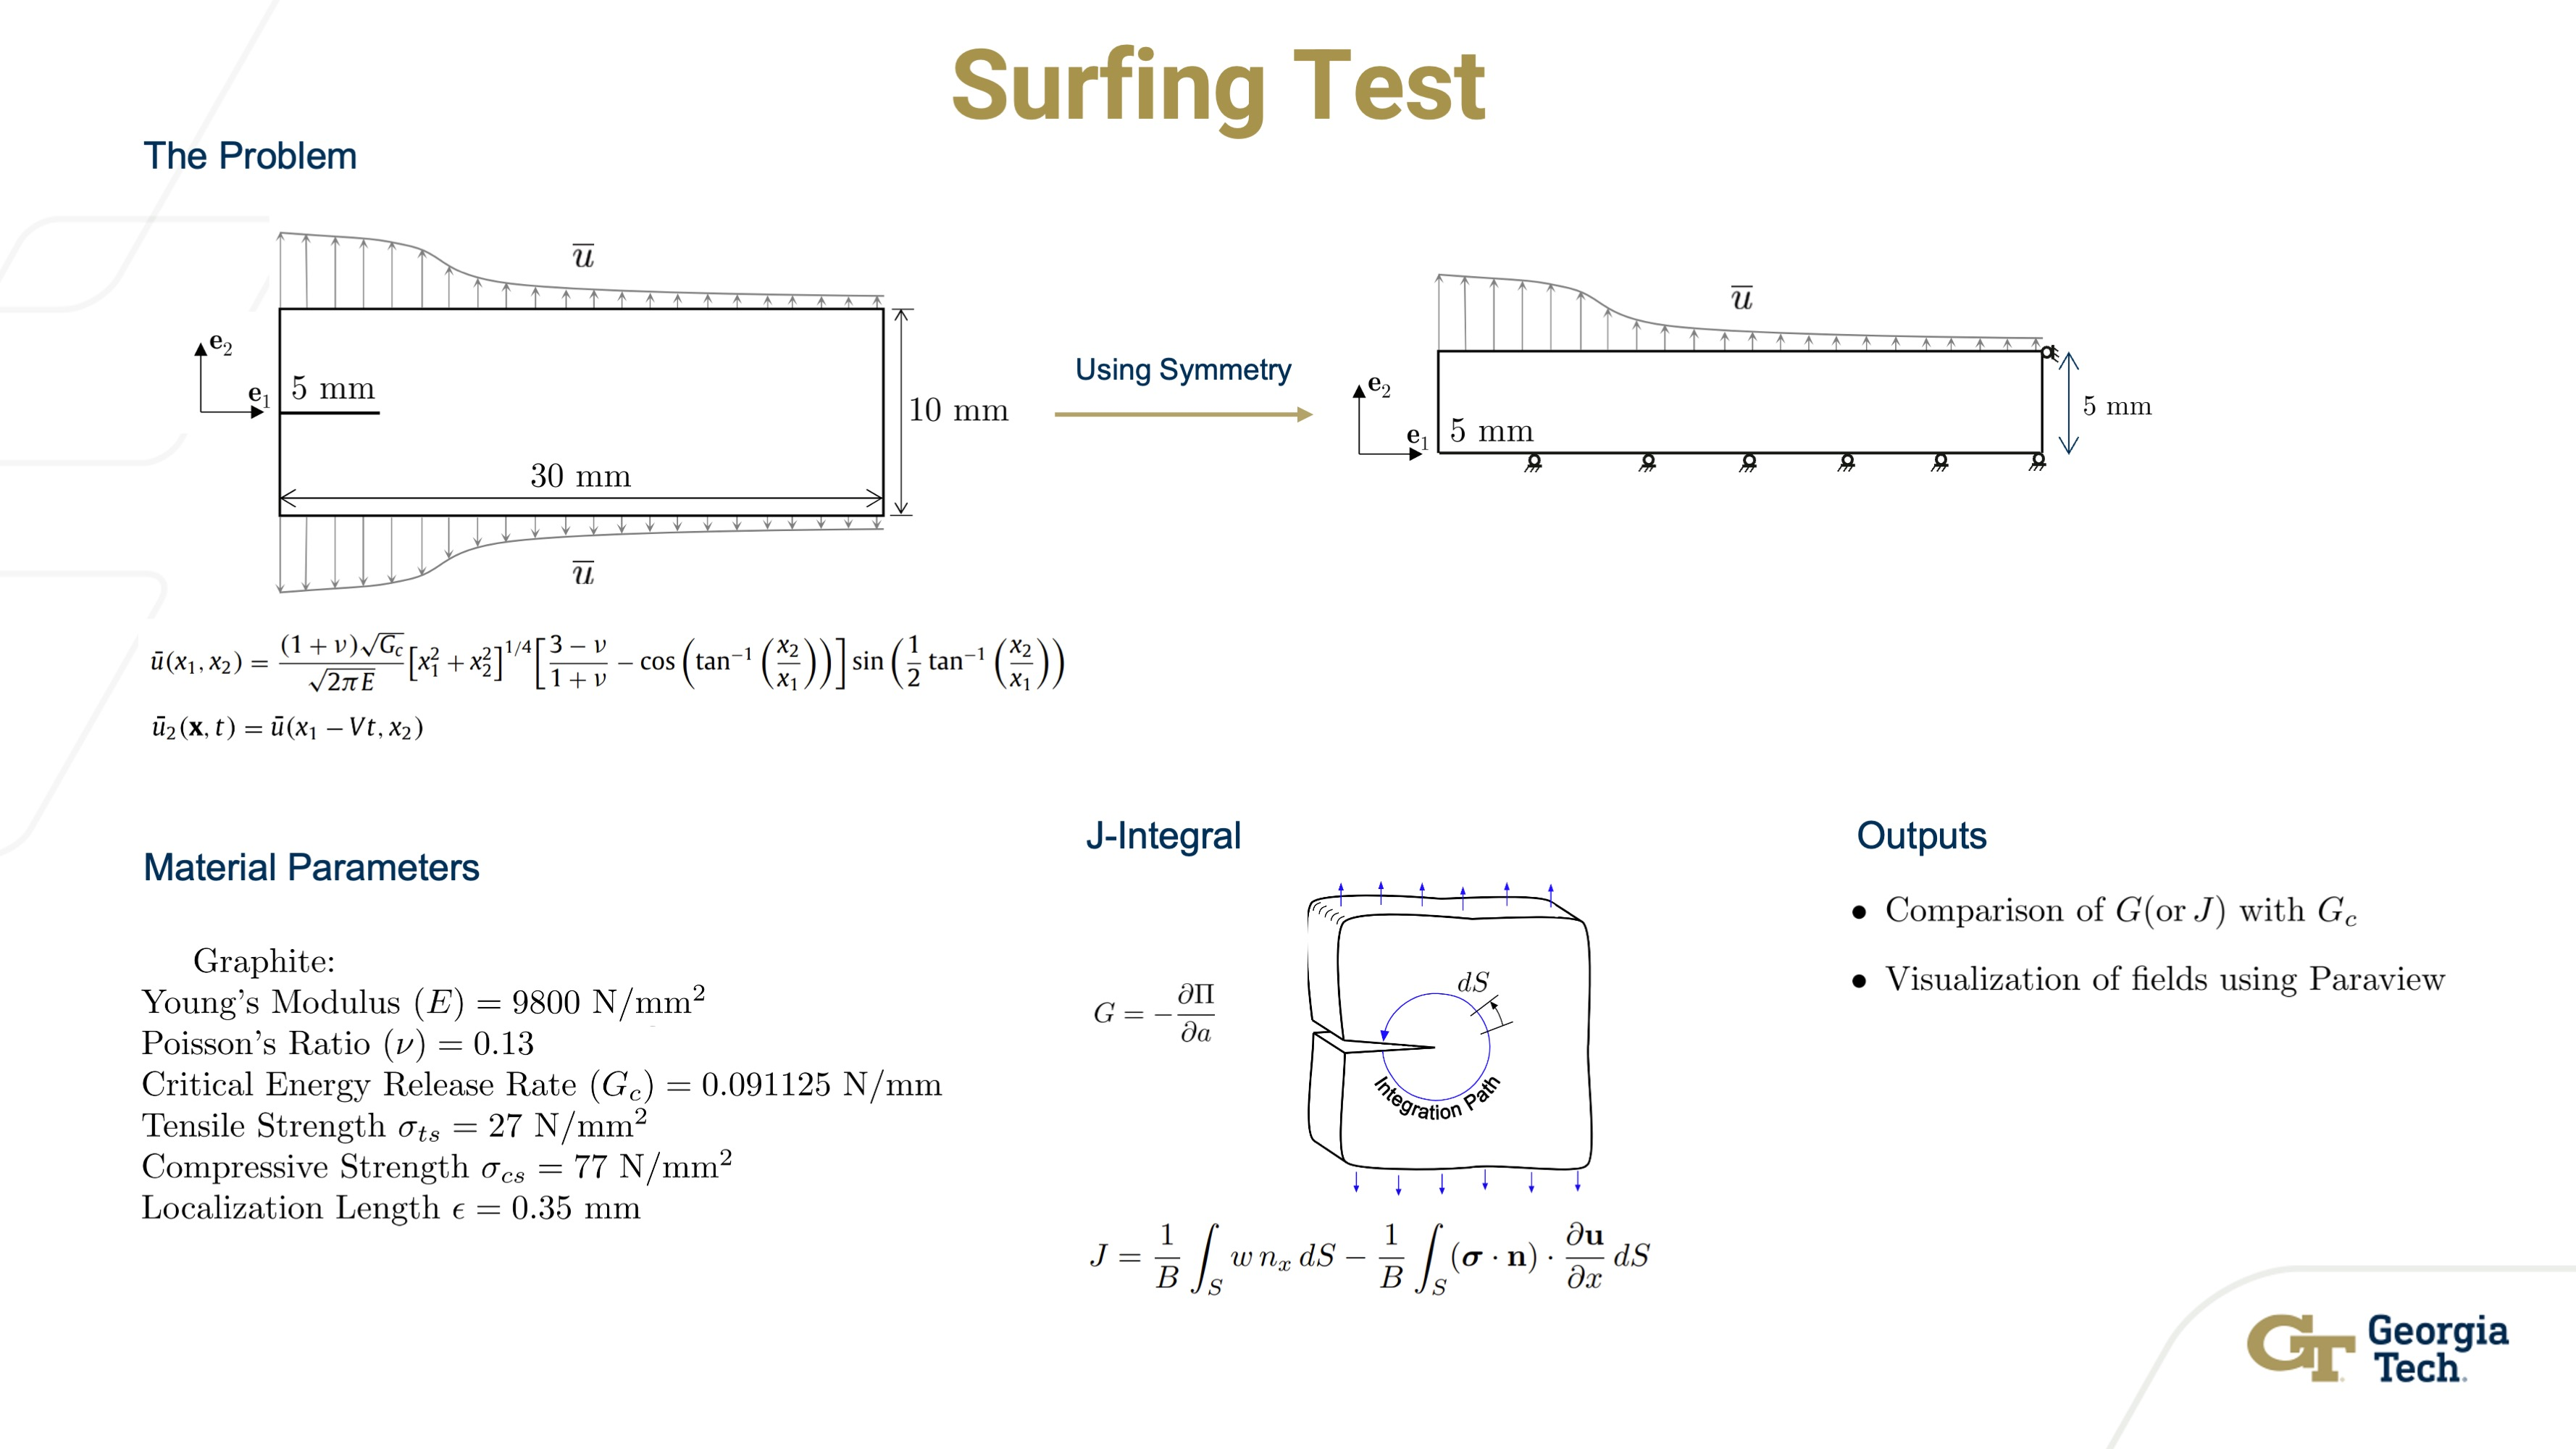

## Connecting to Cybershuttle

In [ ]:
%pip install -q "airavata-python-sdk[notebook]"
import airavata_jupyter_magic

%authenticate
%request_runtime hpc_cpu --file=cybershuttle.yml --walltime=60 --use=NeuroData25VC1:cloud
%switch_runtime hpc_cpu

## Importing the required libraries

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem, io, plot, nls, log, geometry, la
from dolfinx import cpp as _cpp
from dolfinx import default_real_type
import dolfinx.fem.petsc
import ufl
import numpy as np
from petsc4py.PETSc import ScalarType
from petsc4py import PETSc
import time
import os

## Defining material properties

In [ ]:
E, nu = 9800, 0.13                                                               #Young's modulus and Poisson's ratio    
mu, lmbda, kappa = E/(2*(1 + nu)), E*nu/((1 + nu)*(1 - 2*nu)), E/(3*(1 - 2*nu))
Gc= 0.091125		                                                             #Critical energy release rate       

sts, scs= 27, 77	                     #Tensile strength and compressive strength  
shs = (2/3)*sts*scs/(scs-sts)
Wts = sts**2/(2*E)
Whs = shs**2/(2*kappa)

lch = 3*Gc*E/8/(sts**2)                   #Irwin characteristic length = 0.45875
eps = 0.35                                #The regularization length
h = 0.05                                  #The element size

delta = (1+3*h/(8*eps))**(-2) * ((sts + (1+2*np.sqrt(3))*shs)/((8+3*np.sqrt(3))*shs)) * 3*Gc/(16*Wts*eps) + (1+3*h/(8*eps))**(-1) * (2/5)

## Setting up the communicator and the mesh

In [ ]:
comm = MPI.COMM_WORLD
comm_rank = MPI.COMM_WORLD.rank

#Geometry
ac = 5.0                              #notch length
W, L = 30.0, 5.0                      #making use of symmetry

domain = mesh.create_rectangle(comm = comm,points=[np.array([0,0]), np.array([W,L])],n=[int(W/(8*h))
                               ,int(L/(8*h))], cell_type=mesh.CellType.triangle
                               , diagonal= mesh.DiagonalType.left_right)

# Mesh refinement
def cell_criterion2(x):
    return (x[1]<3.5*eps) & (x[0]>ac-20*h)

ir=0
while ir<3:
    domain.topology.create_connectivity(domain.topology.dim, domain.topology.dim)
    cells_local = np.arange(domain.topology.index_map(domain.topology.dim).size_local, dtype=np.int32)
    midpoints = dolfinx.mesh.compute_midpoints(domain, domain.topology.dim, cells_local).T
    should_refine = np.flatnonzero(cell_criterion2(midpoints)).astype(np.int32)
    domain.topology.create_entities(1)
    local_edges = dolfinx.mesh.compute_incident_entities(domain.topology, should_refine, domain.topology.dim, 1)
    domain = dolfinx.mesh.refine(domain, local_edges)[0]
    ir+=1


## Visualizing the mesh

In [ ]:
%pip install pyvista[notebook] panel

import pyvista as pv
from dolfinx.plot import vtk_mesh

# pick your backend as before
pv.set_jupyter_backend('static')   # or 'html', 'client', etc.

# build your mesh…
topology, cell_types, x = vtk_mesh(domain)
grid = pv.UnstructuredGrid(topology, cell_types, x)

# create the Plotter with a larger window
plotter = pv.Plotter(window_size=(3*1200, 3*900))  
plotter.add_mesh(grid, show_edges=True)
plotter.camera_position = 'xy'

plotter.show()

## Initialising function spaces and functions

In [ ]:
V = fem.functionspace(domain, ("Lagrange", 1, (2,)))
Y = fem.functionspace(domain, ("Lagrange", 1)) 
V_stress = fem.functionspace(domain, ("Lagrange", 1, (2,2)))

stress = fem.Function(V_stress, name = "stress")
u  = fem.Function(V, name="displacement")
u_trial = fem.Function(V)
v = ufl.TestFunction(V)
du = ufl.TrialFunction(V)

z  = fem.Function(Y, name="phasefield")
z_trial  = fem.Function(Y)
y  = ufl.TestFunction(Y)
dz = ufl.TrialFunction(Y) 

z_lb = fem.Function(Y, name="Lower bound")
z_ub = fem.Function(Y, name="Upper bound")
z_ub.x.array[:] = 1
z_ub.x.scatter_forward() 
z_lb.x.array[:] = 0
z_lb.x.scatter_forward() 

## Expression for mode I  displacement

In [ ]:
class MyExpression:
    def __init__(self):
        self.t = 0.0
        self.v = 20.0

    def eval(self, x):
        values = np.zeros((1, x.shape[1]))
        values[0,:] = (1/2/mu)*np.sqrt(Gc*E)/np.sqrt(2*np.pi)*\
              (((x[0]-self.v*self.t)**2+L**2)**0.25)*\
              ((3-nu)/(1+nu)-np.cos(np.arctan2(L,(x[0]-self.v*self.t))))*\
              np.sin(0.5*np.arctan2(L,(x[0]-self.v*self.t)))

        return values

V_1, _ = V.sub(1).collapse()
re = MyExpression()
re.t = 0
r = fem.Function(V_1)
r.interpolate(re.eval)

## Setting the Dirichlet part of boundary conditions

In [ ]:
def left(x):
    return np.isclose(x[0], 0)

def front(x):
    return np.isclose(x[0], W)

def top(x):
    return np.isclose(x[1], L)

def bottom(x):
    return (x[1]<1e-4) & (x[0]>ac - 1e-4)

def cracktip(x):
    return (x[1] < 1e-4) & (x[0] > ac - h*10) & (x[0] < ac+1e-4)

def righttop(x):
    return (np.abs(x[1]-L) < h*10) & (np.abs(x[0]-W) < h*10)
    # return (np.abs(x[1]) < h*1.5) & (np.abs(x[0]-W) < h*1)

def outer(x):
    return (x[1] > L/10)

fdim = domain.topology.dim -1
left_facets = mesh.locate_entities_boundary(domain, fdim, left)
front_facets = mesh.locate_entities_boundary(domain, fdim, front)
top_facets = mesh.locate_entities_boundary(domain, fdim, top)
bottom_facets = mesh.locate_entities(domain, fdim, bottom)
cracktip_facets = mesh.locate_entities(domain, fdim, cracktip)
righttop_facets = mesh.locate_entities(domain, fdim, righttop)
outer_facets = mesh.locate_entities(domain, fdim, outer)


dofs_righttop = fem.locate_dofs_topological(V.sub(0), fdim, righttop_facets)
dofs_bottom = fem.locate_dofs_topological(V.sub(1), fdim, bottom_facets)
dofs_top = fem.locate_dofs_topological((V.sub(1), V_1), fdim, top_facets)

dofs_outer = fem.locate_dofs_topological(Y, fdim, outer_facets)
dofs_cracktip = fem.locate_dofs_topological(Y, fdim, cracktip_facets)

bcr = fem.dirichletbc(ScalarType(0), dofs_righttop, V.sub(0))
bcb = fem.dirichletbc(ScalarType(0), dofs_bottom, V.sub(1))
bct = fem.dirichletbc(r, dofs_top, V.sub(1))
bcs_u = [bcr, bcb, bct]


bct_z = fem.dirichletbc(ScalarType(1), dofs_outer, Y)
bcc_z = fem.dirichletbc(ScalarType(0), dofs_cracktip, Y)
bcs_z = [bct_z, bcc_z]

## Marking facets and defining measures

In [ ]:
marked_facets = np.hstack([front_facets, left_facets, top_facets])
marked_values = np.hstack([np.full_like(front_facets, 1),
                           np.full_like(left_facets, 2),
                           np.full_like(top_facets, 3)])

sorted_facets = np.argsort(marked_facets)
facet_tag = mesh.meshtags(domain, domain.topology.dim -1,
                          marked_facets[sorted_facets],
                          marked_values[sorted_facets])

dx = ufl.Measure("dx", domain=domain,  metadata={"quadrature_degree": 4, "quadrature_scheme": "default"} )
ds = ufl.Measure("ds", domain=domain, subdomain_data=facet_tag,  metadata={"quadrature_degree": 4, "quadrature_scheme": "default"})

n = ufl.FacetNormal(domain)

## Imposing the boundary conditions

In [ ]:
u.x.array[:] = 0.
u.x.scatter_forward() 


z.x.array[:] = 1.
fem.petsc.set_bc(z.x.petsc_vec, bcs_z)
z.x.scatter_forward() 

## User defined fucntions for energy, stress, strain and for other utilities

In [ ]:
def local_project(v, V):
    """[summary]
        Helper function to do a interpolation
    Args:
        v ([dolfin.Funcion]): [function to be projected]
        V ([dolfin.Function]): [target `dolfin.FunctionSpace` to be projected on]

    Returns:
        [dolfin.Function]: [target function after projection]

    DOESN'T WORK while propjecting quadrature element to a standard element??why??
    """
    expr = fem.Expression(v, V.element.interpolation_points, comm)
    u = fem.Function(V)
    u.interpolate(expr)
    u.x.scatter_forward()
    return u

def norm_L2(comm, v):
    """Compute the L2(O)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(ufl.inner(v, v) * dx)), op=MPI.SUM))

def energy(v):
	return mu*(ufl.inner(ufl.sym(ufl.grad(v)),ufl.sym(ufl.grad(v))) + ((nu/(1-nu))**2)*(ufl.tr(ufl.sym(ufl.grad(v))))**2 )+  0.5*(lmbda)*(ufl.tr(ufl.sym(ufl.grad(v)))*(1-2*nu)/(1-nu))**2 
	
def epsilon(v):
	return ufl.sym(ufl.grad(v))

def sigma(v):
	return 2.0*mu*ufl.sym(ufl.grad(v)) + (lmbda)*ufl.tr(ufl.sym(ufl.grad(v)))*(1-2*nu)/(1-nu)*ufl.Identity(len(v))

def sigmavm(v):
	sig = sigma(v)
	return ufl.sqrt(1/2*(ufl.inner(sig-1/3*ufl.tr(sig)*ufl.Identity(len(v)), sig-1/3*ufl.tr(sig)*ufl.Identity(len(v))) + (1/9)*ufl.tr(sig)**2 ))

def dgd(z):
    return (z**2 + 1e-5)

## Setting up the solver

In [ ]:
from dolfinx.cpp.log import LogLevel, log

class SNESSolver:
    """
    Problem class for elasticity, compatible with PETSC.SNES solvers.
    """
    def __init__(self, F_form: ufl.Form, u: fem.Function, bcs=[], J_form: ufl.Form = None, bounds=None, petsc_options={},
        form_compiler_parameters={}, jit_parameters={}, monitor=None, prefix=None,):
        self.u = u
        self.bcs = bcs
        self.bounds = bounds
        # Give PETSc solver options a unique prefix
        if prefix is None:
            prefix = "snes_{}".format(str(id(self))[0:4])
        self.prefix = prefix
        if self.bounds is not None:
            self.lb = bounds[0]
            self.ub = bounds[1]
        V = self.u.function_space
        self.comm = V.mesh.comm
        self.F_form = fem.form(F_form)
        if J_form is None:
            J_form = ufl.derivative(F_form, self.u, ufl.TrialFunction(V))
        self.J_form = fem.form(J_form)
        self.petsc_options = petsc_options
        self.monitor = monitor
        self.solver = self.solver_setup()


    def set_petsc_options(self, debug=False):
        # Set PETSc options
        opts = PETSc.Options()
        opts.prefixPush(self.prefix)
        if debug is True:
            ColorPrint.print_info(self.petsc_options)
        for k, v in self.petsc_options.items():
            opts[k] = v
        opts.prefixPop()


    def solver_setup(self):
        # Create nonlinear solver
        snes = PETSc.SNES().create(self.comm)
        # Set options
        snes.setOptionsPrefix(self.prefix)
        self.set_petsc_options()
        snes.setFromOptions()
        self.b = fem.petsc.create_vector(self.F_form)
        self.a = fem.petsc.create_matrix(self.J_form)
        snes.setFunction(self.F, self.b)
        snes.setJacobian(self.J, self.a)
        # We set the bound (Note: they are passed as reference and not as values)
        if self.monitor is not None:
            snes.setMonitor(self.monitor)
        if self.bounds is not None:
            snes.setVariableBounds(self.lb.x.petsc_vec, self.ub.x.petsc_vec)
        return snes


    def F(self, snes: PETSc.SNES, x: PETSc.Vec, b: PETSc.Vec):
        """Assemble the residual F into the vector b."""
        x.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
        x.copy(self.u.x.petsc_vec)  # Updated line
        self.u.x.scatter_forward()
        # Zero the residual vector
        with b.localForm() as b_local:
            b_local.set(0.0)
        fem.petsc.assemble_vector(b, self.F_form)
        # this is a nasty workaround to include the force term with the bug https://github.com/FEniCS/dolfinx/issues/2664
        # force_form = fem.form(-F_ext(v))
        # b_ds = fem.petsc.create_vector(force_form)
        # fem.petsc.assemble_vector(b_ds,force_form)
        # b.array[:] += b_ds.array
        
        # Apply boundary conditions
        fem.petsc.apply_lifting(b, [self.J_form], [self.bcs], [x], -1.0)
        b.ghostUpdate(addv=PETSc.InsertMode.ADD, mode=PETSc.ScatterMode.REVERSE)
        fem.petsc.set_bc(b, self.bcs, x, -1.0)


    def J(self, snes, x: PETSc.Vec, A: PETSc.Mat, P: PETSc.Mat):
        """Assemble the Jacobian matrix.
        Parameters
        ==========
        x: Vector containing the latest solution.
        A: Matrix to assemble the Jacobian into.
        """
        A.zeroEntries()
        fem.petsc.assemble_matrix(A, self.J_form, self.bcs)
        A.assemble()


    def solve(self):
        log(LogLevel.INFO, f"Solving {self.prefix}")
        try:
            self.solver.solve(None, self.u.x.petsc_vec)  # Updated line
            self.u.x.scatter_forward()
            return (self.solver.getIterationNumber(), self.solver.getConvergedReason())
        except Warning:
            log(
                LogLevel.WARNING,
                f"WARNING: {self.prefix} solver failed to converge, what's next?",
            )
            raise RuntimeError(f"{self.prefix} solvers did not converge")       

petsc_options_SNES_u = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 1.0e-08,
    "snes_max_it": 10,
    "snes_monitor": "",
}
petsc_options_SNES_z = {
    "snes_type": "vinewtonrsls",
    "snes_linesearch_type": "basic",
    "ksp_type": "preonly",
    "pc_type": "lu",
    "pc_factor_mat_solver_type": "mumps",
    "snes_atol": 1.0e-08,
    "snes_rtol": 1.0e-08,
    "snes_stol": 1.0e-08,
    "snes_max_it": 10,
    "snes_monitor": "",
}

## Weak form of the PDE for the displacement

In [ ]:
psi1 = dgd(z)*(energy(u))
psi11 = energy(u)
Pi = psi1*dx #- ufl.dot(Tf, u)*ds(1)

R_u = ufl.derivative(Pi, u, v)
J_u = ufl.derivative(R_u, u, du)
problem_u = SNESSolver(R_u, u, J_form = J_u, bcs = bcs_u, petsc_options=petsc_options_SNES_u)

## Defining the external force $c_e$ in the phase field equation

In [ ]:
I1_d = dgd(z)*ufl.tr(sigma(u))
SQJ2_d = dgd(z)*sigmavm(u)

beta1 = -(delta*Gc)/(shs*8*eps) + (2*Whs)/(3*shs)
beta2 = -(3**0.5*(3*shs - sts)*delta*Gc)/(shs*sts*8*eps) - (2*Whs)/(3**0.5*shs) + (2*3**0.5*Wts)/(sts)

ce = beta2*SQJ2_d + beta1*I1_d + z*(1-ufl.sqrt(I1_d**2)/I1_d)*psi11 

## Weak form of the PDE for the phase field

In [ ]:
R_z = y*2*z*(psi11)*dx - y*(ce)*dx + 3*delta*Gc/8*(-y/eps + 2*eps*ufl.inner(ufl.grad(z),ufl.grad(y)))*dx
J_z = ufl.derivative(R_z, z, dz)
problem_z = SNESSolver(R_z, z, J_form = J_z, bcs = bcs_z, petsc_options=petsc_options_SNES_z, bounds=(z_lb, z_ub))

## Setting the time step parameters

In [ ]:
tol = 1e-8
T = 1; Totalsteps = 50; stepsize = T/Totalsteps
t = stepsize; tau=0
step=1

## Solving the problem over several time steps via a staggered scheme and post-processing (t = 0 to 0.5)

In [ ]:
while t-stepsize < 0.5:
    
	re.t=t
	r.interpolate(re.eval)

	if comm_rank==0:
		print(f"\n------ Solve for Step = {step} ------ t={t:5.5f} -------")

	stag_iter = 1; zres = 1e7;# ures = 1e7

	mask = z.x.array <= 0.05
	z_ub.x.array[mask] = z.x.array[mask] + .002
	z_ub.x.scatter_forward() 

	while (stag_iter < 50) and (zres > tol):
          
		start_time=time.time()

		if comm_rank==0:
			print(f"-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-")

		out = problem_u.solve()  #Solving for u
		u.x.scatter_forward()

		if comm_rank==0:
			print(f"-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-")

		z_trial.x.array[:] = z.x.array
		out = problem_z.solve()  #Solving for z
		z.x.scatter_forward()
		zres = norm_L2(comm, z_trial - z)

		if comm_rank==0:
			print(f"====Iter={stag_iter}====zres={zres:.7e}===={time.time() - start_time:.4f}")

		stag_iter += 1


	JI = fem.form((-ufl.dot(ufl.dot(sigma(u), n), u.dx(0)))*ds(3)\
					+ (psi1*n[0]  - ufl.dot(ufl.dot(sigma(u), n), u.dx(0))) * ds(1)\
					+ (psi1*n[0]  - ufl.dot(ufl.dot(sigma(u), n), u.dx(0))) * ds(2))
     
	Jintegral = domain.comm.allreduce(fem.assemble_scalar(JI), op=MPI.SUM)


	if comm_rank==0:
		with open('Surfing.txt', 'a') as rfile:
			rfile.write(f"{t:.5f}  {2*Jintegral:.5f} \n") 

	if step % 1==0:
		vtk = io.VTKFile(domain.comm, f"paraview/_Model_{step}.pvd", "w")
		#stress.x.array[:] = (local_project(dgd(z)*sigma(u), V_stress)).x.array
		#stress.name = "stress"
		#vtk.write_function([u, z, stress], t)
		vtk.write_function([u, z], t)
		vtk.close()

	tau += stepsize
	t += stepsize
	step += 1

## Results upto t=0.5
Plot of energy release rate

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Load data: assume two whitespace‐separated columns [t, J]
data = np.loadtxt('Surfing.txt')
time_data = data[:, 0]
J = data[:, 1]

# Create the plot
plt.figure(figsize=(10,8))
plt.plot(time_data, J, marker='o', linestyle='-')

# Plot the horizontal line y = 0.091125
plt.axhline(0.091125, linestyle='--',color='red', label='Gc')

plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 0.1, 0.01))

plt.axis([0, 1, 0, 0.1])
plt.xlabel('Time', fontsize=16)
plt.ylabel('J‐integral (N/mm)', fontsize=16)
plt.title('J‐integral vs Time', fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.show()

## Downloading vtk files for visualization

In [ ]:
!tar cvzf paraview.tar.gz paraview

In [ ]:
%copy_data source=hpc_cpu:paraview.tar.gz target=local:.

## Solving the problem over several time steps via a staggered scheme and post-processing (t = 0.5 to 1)

In [ ]:
while t-stepsize < 1:
    
	re.t=t
	r.interpolate(re.eval)

	if comm_rank==0:
		print(f"\n------ Solve for Step = {step} ------ t={t:5.5f} -------")

	stag_iter = 1; zres = 1e7;# ures = 1e7

	mask = z.x.array <= 0.05
	z_ub.x.array[mask] = z.x.array[mask] + .002
	z_ub.x.scatter_forward() 

	while (stag_iter < 50) and (zres > tol):
          
		start_time=time.time()

		if comm_rank==0:
			print(f"-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-u-")

		out = problem_u.solve()  #Solving for u
		u.x.scatter_forward()

		if comm_rank==0:
			print(f"-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-z-")

		z_trial.x.array[:] = z.x.array
		out = problem_z.solve()  #Solving for z
		z.x.scatter_forward()
		zres = norm_L2(comm, z_trial - z)

		if comm_rank==0:
			print(f"====Iter={stag_iter}====zres={zres:.7e}===={time.time() - start_time:.4f}")

		stag_iter += 1


	JI = fem.form((-ufl.dot(ufl.dot(sigma(u), n), u.dx(0)))*ds(3)\
					+ (psi1*n[0]  - ufl.dot(ufl.dot(sigma(u), n), u.dx(0))) * ds(1)\
					+ (psi1*n[0]  - ufl.dot(ufl.dot(sigma(u), n), u.dx(0))) * ds(2))
     
	Jintegral = domain.comm.allreduce(fem.assemble_scalar(JI), op=MPI.SUM)


	if comm_rank==0:
		with open('Surfing.txt', 'a') as rfile:
			rfile.write(f"{t:.5f}  {2*Jintegral:.5f} \n") 

	if step % 1==0:
		vtk = io.VTKFile(domain.comm, f"paraview/_Model_{step}.pvd", "w")
		#stress.x.array[:] = (local_project(dgd(z)*sigma(u), V_stress)).x.array
		#stress.name = "stress"
		#vtk.write_function([u, z, stress], t)
		vtk.write_function([u, z], t)
		vtk.close()

	tau += stepsize
	t += stepsize
	step += 1

## Final Results
Plot of energy release rate

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Load data: assume two whitespace‐separated columns [t, J]
data = np.loadtxt('Surfing.txt')
time_data = data[:, 0]
J = data[:, 1]

# Create the plot
plt.figure(figsize=(10,8))
plt.plot(time_data, J, marker='o', linestyle='-')

# Plot the horizontal line y = 0.091125
plt.axhline(0.091125, linestyle='--',color='red', label='Gc')

plt.xticks(np.arange(0, 1, 0.1))
plt.yticks(np.arange(0, 0.1, 0.01))

plt.axis([0, 1, 0, 0.1])
plt.xlabel('Time', fontsize=16)
plt.ylabel('J‐integral (N/mm)', fontsize=16)
plt.title('J‐integral vs Time', fontsize=18)
plt.grid(True)
plt.tight_layout()

plt.show()

## Downloading vtk files for visualization

In [ ]:
!tar cvzf paraview_full.tar.gz paraview

In [ ]:
%copy_data source=hpc_cpu:paraview_full.tar.gz target=local:.